<a href="https://colab.research.google.com/github/UncurledGuide/stock_data_analysis/blob/main/LULU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from pytrends.request import TrendReq
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


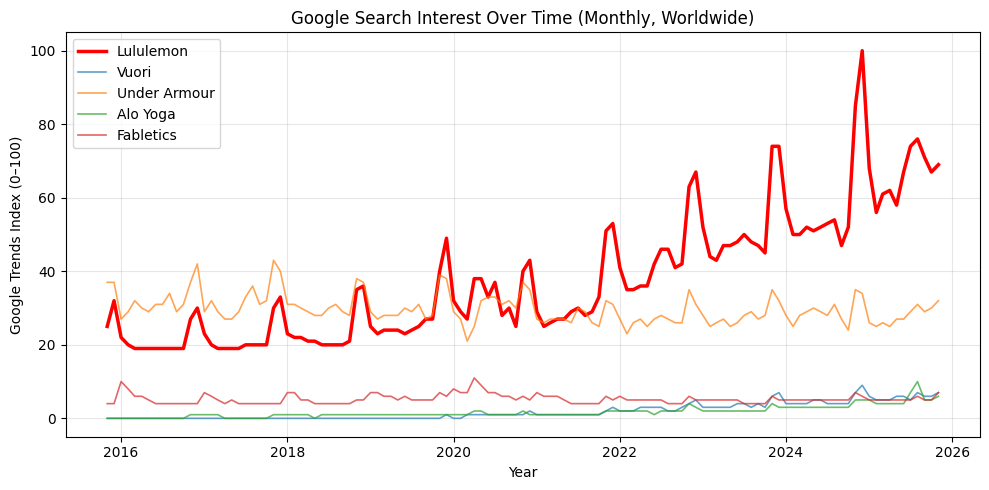

In [ ]:
pytrends = TrendReq(hl='en-US', tz=360)

# Example peer set
kw_list = ["lululemon", "vuori", "under armour", "alo yoga", "fabletics"]

pytrends.build_payload(
    kw_list=kw_list,
    timeframe='2015-11-10 2025-11-10',  # set range to match LULU listing + data period
    geo='',  # or 'CA', 'GB', etc; 'US' is a good start
    gprop=''   # web search
)

interest = pytrends.interest_over_time()
interest = interest.drop(columns=['isPartial'])  # drop flag


interest.index = pd.to_datetime(interest.index)
interest = interest.sort_index()

# ---------- PANEL A: Time series of interest ----------
fig, ax = plt.subplots(figsize=(10, 5))

for col in interest.columns:
    if col == "lululemon":
        ax.plot(interest.index, interest[col], label=col.title(), linewidth=2.5, color='Red')
    else:
        ax.plot(interest.index, interest[col], label=col.title(), linewidth=1.2, alpha=0.7)

ax.set_title("Google Search Interest Over Time (Monthly, Worldwide)")
ax.set_xlabel("Year")
ax.set_ylabel("Google Trends Index (0–100)")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

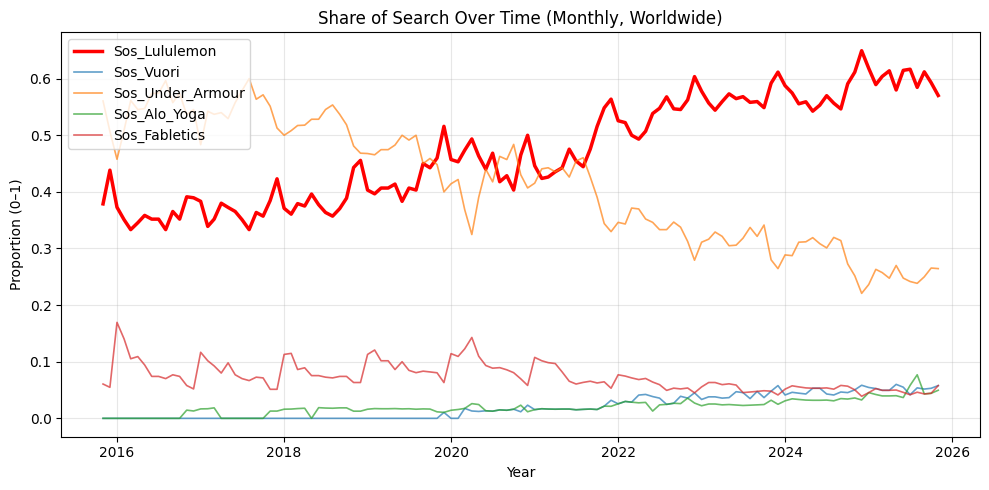

In [ ]:
# Sum across all brands each date
total_interest = interest[kw_list].sum(axis=1)

sos = interest[kw_list].div(total_interest, axis=0)
sos.columns = [f"SoS_{c.replace(' ', '_')}" for c in sos.columns]

# Optional: combine into one DataFrame
trend_df = pd.concat([interest, sos], axis=1)
trend_df

fig, ax = plt.subplots(figsize=(10, 5))

for col in sos.columns:
    if col == "SoS_lululemon":
        ax.plot(sos.index, sos[col], label=col.title(), linewidth=2.5, color='Red')
    else:
        ax.plot(sos.index, sos[col], label=col.title(), linewidth=1.2, alpha=0.7)

ax.set_title("Share of Search Over Time (Monthly, Worldwide)")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion (0–1)")
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
tickers = ["LULU", "UAA", "SPY"]

price_data = yf.download(
    tickers,
    start="2013-01-01",
    end="2025-11-10",
    interval="1wk"  # weekly to roughly match Trends
)

# yfinance returns a multi-index; adjust for Close prices
prices = price_data['Close'].dropna()

prices


/tmp/ipython-input-2102574641.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(
[*********************100%***********************]  3 of 3 completed


Ticker,LULU,SPY,UAA
Date,,,
2013-01-01,71.099998,116.881813,12.1075
2013-01-08,72.300003,117.682526,12.0850
2013-01-15,66.800003,118.771530,11.5650
2013-01-22,70.000000,120.164803,11.9775
2013-01-29,66.820000,119.740387,12.4900
...,...,...,...
2025-10-07,169.850006,663.039978,4.8400
2025-10-14,172.429993,671.299988,4.7300
2025-10-21,181.389999,685.239990,4.8500


In [ ]:
import requests
import pandas as pd

API_KEY = "V67UL3B87SE5WD6F"
symbol = "LULU"

url = "https://www.alphavantage.co/query"
params = {
    "function": "INCOME_STATEMENT",
    "symbol": symbol,
    "apikey": API_KEY
}

r = requests.get(url, params=params)
data = r.json()
# 'quarterlyReports' is a list of dicts, each a quarter
q = pd.DataFrame(data["quarterlyReports"])

# Keep only what you need
q["fiscalDateEnding"] = pd.to_datetime(q["fiscalDateEnding"])
q = q.set_index("fiscalDateEnding").sort_index()

# Revenue as numeric
q["totalRevenue"] = pd.to_numeric(q["totalRevenue"], errors="coerce")

# Now you have many quarters of revenue you can join to SoS_q
print(q[["totalRevenue"]])

trend_df.index = pd.to_datetime(trend_df.index)
trend_df = trend_df.sort_index()

q.index = pd.to_datetime(q.index)
q = q.sort_index()


                  totalRevenue
fiscalDateEnding              
2005-07-31            21032273
2005-10-31            21032273
2006-01-31            21032273
2006-04-30            28183582
2006-07-31            40233751
...                        ...
2024-07-31          2371078000
2024-10-31          2396660000
2025-01-31          3611497000
2025-04-30          2370660000
2025-07-31          2525219000

[81 rows x 1 columns]


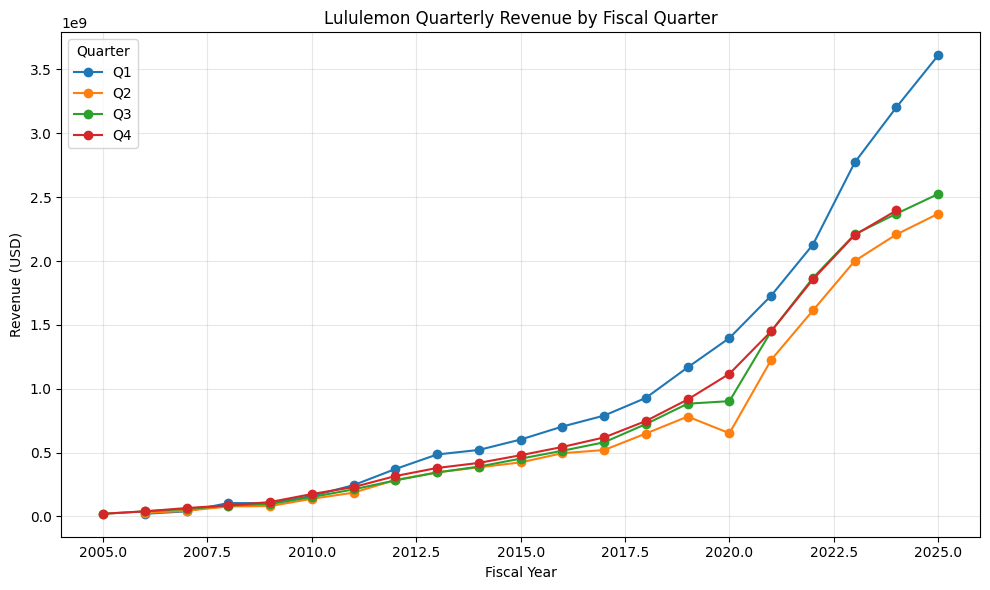

In [ ]:
def map_quarter(dt):
    # customize to your fiscal calendar
    if dt.month == 1 and dt.day == 31:
        return "Q1"
    elif dt.month == 4 and dt.day == 30:
        return "Q2"
    elif dt.month == 7 and dt.day == 31:
        return "Q3"
    elif dt.month == 10 and dt.day == 31:
        return "Q4"
    else:
        return None  # in case there are odd dates

q = q.copy()
q["quarter"] = q.index.to_series().apply(map_quarter)
q["year"] = q.index.year

# drop any rows that didn't map cleanly
q = q.dropna(subset=["quarter"])

# --- 2. Pivot: rows = year, columns = quarter, values = revenue ---

pivot = q.pivot(index="year", columns="quarter", values="totalRevenue")
pivot = pivot.sort_index()

# --- 3. Line chart: each line = a quarter over years ---

plt.figure(figsize=(10, 6))

for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=col)

plt.title("Lululemon Quarterly Revenue by Fiscal Quarter")
plt.xlabel("Fiscal Year")
plt.ylabel("Revenue (USD)")
plt.legend(title="Quarter")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --- Quarterly SoS ---
sos_tmp = trend_df[["SoS_lululemon"]].copy()
sos_tmp["quarter"] = sos_tmp.index.to_period("Q")
sos_q = sos_tmp.groupby("quarter")["SoS_lululemon"].mean()
sos_q.name = "SoS_q"

# --- Quarterly revenue ---
rev_tmp = q[["totalRevenue"]].copy()
rev_tmp["quarter"] = rev_tmp.index.to_period("Q")
# If there’s ever more than one row per quarter, keep the last
rev_q = rev_tmp.groupby("quarter")["totalRevenue"].last()
rev_q.name = "revenue_q"

# Merge on quarter
df_q = pd.concat([sos_q, rev_q], axis=1, join="inner")

# YoY revenue growth (4 quarters back)
df_q["rev_yoy"] = df_q["revenue_q"].pct_change(4)

# Use previous quarter's SoS to predict this quarter's growth
df_q["SoS_lead1"] = df_q["SoS_q"].shift(1)

# Drop missing values created by lagging & YoY
df_q_clean = df_q.dropna(subset=["rev_yoy", "SoS_lead1"])



In [ ]:
import statsmodels.api as sm

y = df_q_clean["revenue_q"]
X = df_q_clean[["SoS_lead1"]]        # predictor
X = sm.add_constant(X)               # add intercept

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              revenue_q   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     228.7
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           1.16e-16
Time:                        01:30:36   Log-Likelihood:                -752.77
No. Observations:                  36   AIC:                             1510.
Df Residuals:                      34   BIC:                             1513.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.705e+09   2.85e+08     -9.507      0.0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


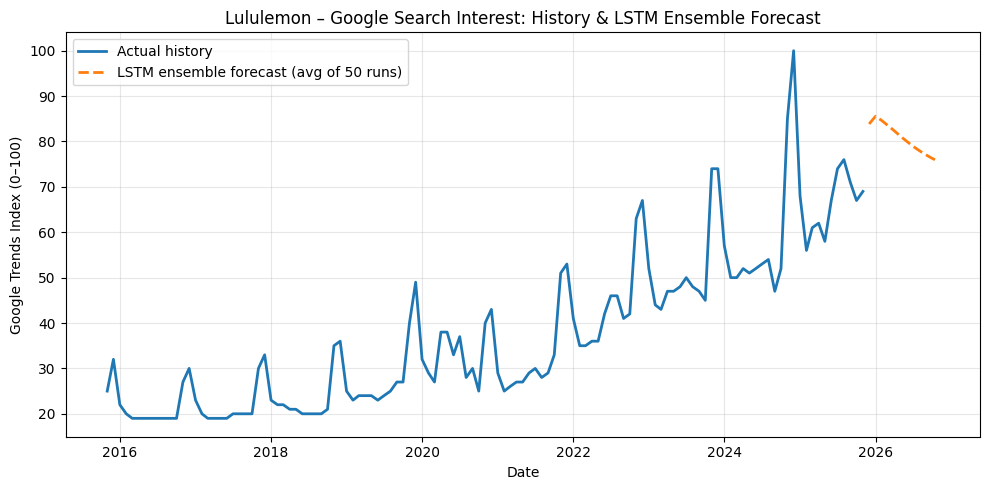

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- LSTM ensemble: train + forecast + average --------

n_runs = 50  # number of LSTM runs to average
future_steps = 12 # Define future_steps before the function

def train_and_forecast_once():
    """Train a single LSTM and return its forecast in *scaled* space."""
    model = Sequential([
        LSTM(32, input_shape=(timesteps, features)), # Changed n_features to features
        Dense(features)  # predict all brands at once, changed n_features to features
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss="mse")

    model.fit(X_train, y_train, epochs=80, batch_size=8, verbose=0)

    # start from last `window` months of *scaled* data
    current_window = scaled.values[-window:, :]  # Changed scaled_interest to scaled
    future_scaled = []

    for _ in range(future_steps):
        X_input = current_window[np.newaxis, :, :]              # (1, window, features)
        y_hat_scaled = model.predict(X_input, verbose=0)[0]     # (features,)
        future_scaled.append(y_hat_scaled)
        # slide window: drop first row, append prediction
        current_window = np.vstack([current_window[1:], y_hat_scaled])

    return np.array(future_scaled)   # (future_steps, features)


# Run the model `n_runs` times and stack the forecasts
all_runs = np.stack([train_and_forecast_once() for _ in range(n_runs)], axis=0)
# all_runs shape: (n_runs, future_steps, features)

# Average across runs -> ensemble forecast in scaled space
avg_future_scaled = all_runs.mean(axis=0)  # (future_steps, features)

# Invert scaling back to original Google Trends units
avg_future_values = scaler.inverse_transform(avg_future_scaled)

future_df = pd.DataFrame(avg_future_values, columns=interest.columns)

# Build date index for the forecast horizon
freq = pd.infer_freq(interest.index)
if freq is None:
    freq = "MS"

last_date = interest.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.DateOffset(months=1),
    periods=future_steps,
    freq=freq
)
future_df.index = future_index

# -------- Example plot: Lululemon ensemble forecast --------

brand = "lululemon"

plt.figure(figsize=(10, 5))
plt.plot(interest.index, interest[brand], label="Actual history", linewidth=2)
plt.plot(future_df.index, future_df[brand],
         linestyle="--",
         label=f"LSTM ensemble forecast (avg of {n_runs} runs)",
         linewidth=2)

plt.title(f"{brand.title()} – Google Search Interest: History & LSTM Ensemble Forecast")
plt.xlabel("Date")
plt.ylabel("Google Trends Index (0–100)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

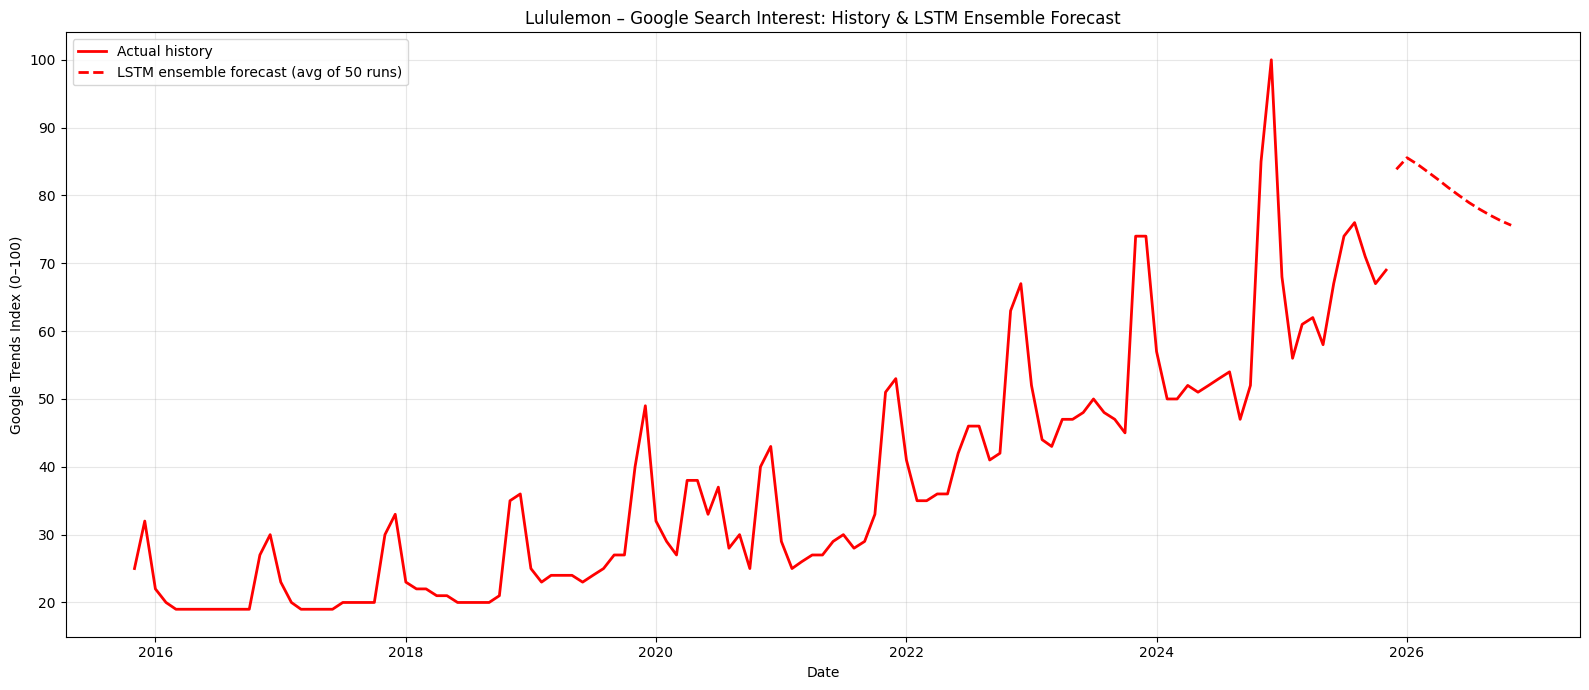

In [ ]:
# -------- Example plot: Lululemon ensemble forecast --------

brand = "lululemon"

plt.figure(figsize=(16, 7))
plt.plot(interest.index, interest[brand], label="Actual history", linewidth=2, color='red')
plt.plot(future_df.index, future_df[brand],
         linestyle="--",
         label=f"LSTM ensemble forecast (avg of {n_runs} runs)",
         linewidth=2, color='red')

plt.title(f"{brand.title()} – Google Search Interest: History & LSTM Ensemble Forecast")
plt.xlabel("Date")
plt.ylabel("Google Trends Index (0–100)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Make sure index is datetime & sorted
interest.index = pd.to_datetime(interest.index)
interest = interest.sort_index()

# Fill any tiny gaps
interest = interest.fillna(method="ffill").fillna(method="bfill")

# Scale to [0,1] for the NN
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(interest.values)
scaled = pd.DataFrame(scaled_values, index=interest.index, columns=interest.columns)

def create_sequences(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :])      # last 12 months
        y.append(data[i+window, :])        # next month
    return np.array(X), np.array(y)

window = 12
values = scaled.values
X_all, y_all = create_sequences(values, window=window)

print("X_all shape:", X_all.shape)  # (samples, 12, num_brands)
print("y_all shape:", y_all.shape)  # (samples, num_brands)

X_train, y_train = X_all, y_all
timesteps = X_train.shape[1]
features  = X_train.shape[2]


X_all shape: (109, 12, 5)
y_all shape: (109, 5)


/tmp/ipython-input-4217397862.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interest = interest.fillna(method="ffill").fillna(method="bfill")


In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(32, input_shape=(timesteps, features)),
    Dense(features)   # predict all brands at once
])

model.compile(optimizer=Adam(learning_rate=0.01), loss="mse")

history = model.fit(
    X_train, y_train,
    epochs=100,      # you can cut to 50 if slow
    batch_size=8,
    verbose=0
)

print("Final training loss:", history.history["loss"][-1])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Final training loss: 0.0014561093412339687


In [ ]:
# Last 'window' points as initial input
last_window = scaled.values[-window:, :]   # shape (12, num_brands)

future_steps = 12
future_scaled = []

current_window = last_window.copy()

for _ in range(future_steps):
    # Model expects shape (1, timesteps, features)
    X_input = current_window[np.newaxis, :, :]
    y_hat = model.predict(X_input, verbose=0)[0]   # shape (num_brands,)

    future_scaled.append(y_hat)

    # Slide the window: drop first row, append prediction
    current_window = np.vstack([current_window[1:], y_hat])

future_scaled = np.array(future_scaled)  # (12, num_brands)

# Invert scaling back to Google Trends units
future_values = scaler.inverse_transform(future_scaled)
future_df = pd.DataFrame(future_values, columns=interest.columns)

# Try to infer the monthly frequency; fall back to 'MS' if None
freq = pd.infer_freq(interest.index)
if freq is None:
    freq = "MS"   # month start

last_date = interest.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.DateOffset(months=1),
    periods=future_steps,
    freq=freq
)

future_df.index = future_index
# Try to infer the monthly frequency; fall back to 'MS' if None
freq = pd.infer_freq(interest.index)
if freq is None:
    freq = "MS"   # month start

last_date = interest.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.DateOffset(months=1),
    periods=future_steps,
    freq=freq
)

future_df.index = future_index


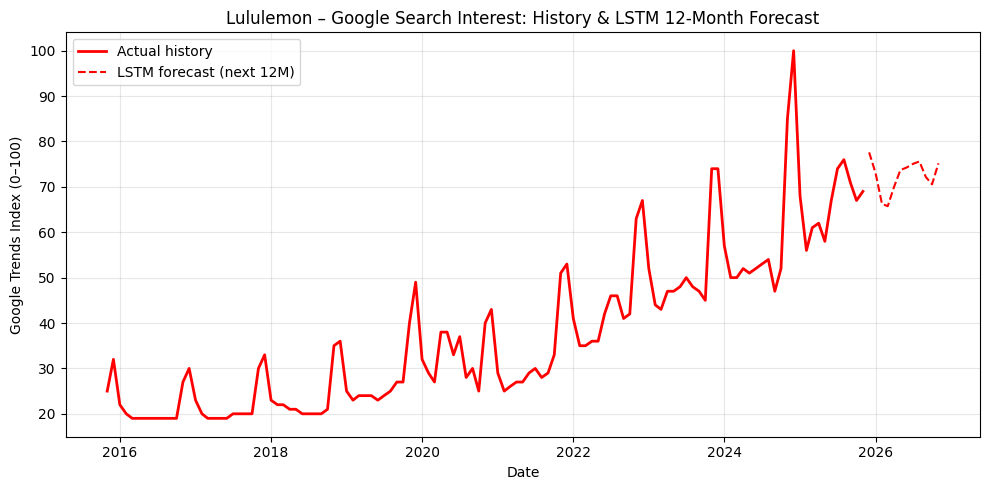

In [ ]:
brand = "lululemon"

plt.figure(figsize=(10, 5))
plt.plot(interest.index, interest[brand], label="Actual history", linewidth=2, color='red')
plt.plot(future_df.index, future_df[brand], label="LSTM forecast (next 12M)", linestyle="--", color='red')

plt.title("Lululemon – Google Search Interest: History & LSTM 12-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Google Trends Index (0–100)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# interest: monthly Google Trends index for each brand
# columns = ["lululemon", "vuori", "under armour", "alo yoga", "fabletics"]

interest.index = pd.to_datetime(interest.index)
interest = interest.sort_index()
interest = interest.fillna(method="ffill").fillna(method="bfill")

# Compute share of search each month
sos = interest.div(interest.sum(axis=1), axis=0)
sos.columns = [f"SoS_{c.replace(' ', '_')}" for c in sos.columns]

# SoS is now in [0,1] and each row sums to 1
print(sos.head())


            SoS_lululemon  SoS_vuori  SoS_under_armour  SoS_alo_yoga  \
date                                                                   
2015-11-01       0.378788        0.0          0.560606           0.0   
2015-12-01       0.438356        0.0          0.506849           0.0   
2016-01-01       0.372881        0.0          0.457627           0.0   
2016-02-01       0.350877        0.0          0.508772           0.0   
2016-03-01       0.333333        0.0          0.561404           0.0   

            SoS_fabletics  
date                       
2015-11-01       0.060606  
2015-12-01       0.054795  
2016-01-01       0.169492  
2016-02-01       0.140351  
2016-03-01       0.105263  


/tmp/ipython-input-3938079572.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interest = interest.fillna(method="ffill").fillna(method="bfill")


In [ ]:


values = sos.values      # shape (T, num_brands)
window = 12              # use last 12 months to predict next month

def create_sequences(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :])     # last 12 months of SoS
        y.append(data[i+window, :])       # next month of SoS
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(values, window=window)
print("X_all:", X_all.shape, "y_all:", y_all.shape)

X_train, y_train = X_all, y_all
timesteps = X_train.shape[1]
features  = X_train.shape[2]


X_all: (109, 12, 5) y_all: (109, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(32, input_shape=(timesteps, features)),
    Dense(features, activation="linear")   # output SoS for all brands
])

model.compile(optimizer=Adam(learning_rate=0.01), loss="mse")

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    verbose=0
)

print("Final training loss:", history.history["loss"][-1])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Final training loss: 0.0003145128139294684


In [ ]:
# Starting window: last 12 months of SoS
last_window = values[-window:, :]   # shape (12, num_brands)

future_steps = 12 # 12 = 1 year, 24 = 2 years, etc.
future_sos = []

current_window = last_window.copy()

for _ in range(future_steps):
    X_input = current_window[np.newaxis, :, :]   # shape (1, 12, num_brands)
    y_hat = model.predict(X_input, verbose=0)[0] # shape (num_brands,)

    # OPTIONAL: renormalize so shares sum to 1
    total = y_hat.sum()
    if total > 0:
        y_hat = y_hat / total

    future_sos.append(y_hat)

    # Slide window forward: drop oldest row, append prediction
    current_window = np.vstack([current_window[1:], y_hat])

future_sos = np.array(future_sos)   # (future_steps, num_brands)


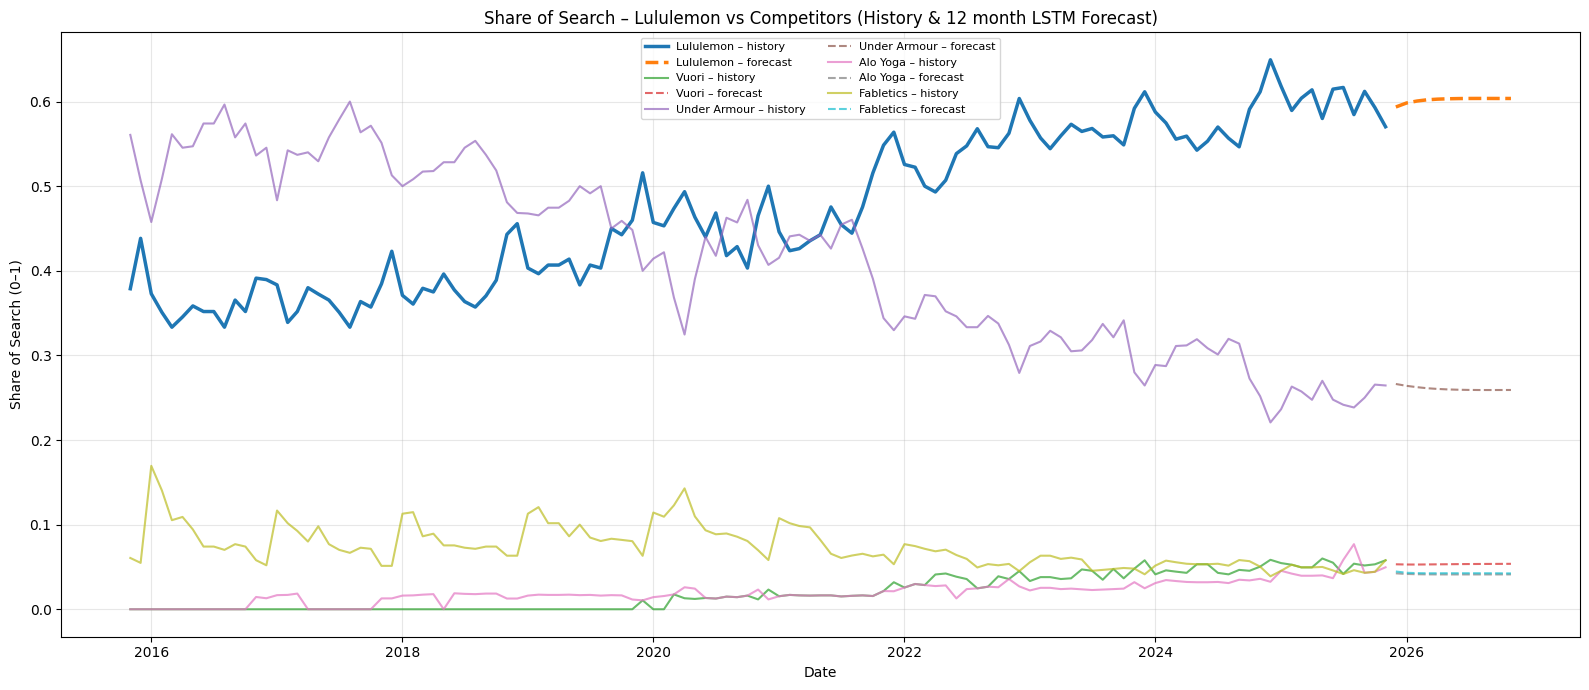

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 7))

for col in sos.columns:
    # Pretty label like "Lululemon", "Vuori", etc.
    base_name = col.replace("SoS_", "").replace("_", " ").title()

    # Make Lululemon stand out a bit
    is_lulu = "lululemon" in col.lower()
    lw = 2.5 if is_lulu else 1.5
    alpha = 1.0 if is_lulu else 0.7

    # Historical SoS
    plt.plot(
        sos.index,
        sos[col],
        label=f"{base_name} – history",
        linewidth=lw,
        alpha=alpha,
    )

    # Forecast SoS
    plt.plot(
        future_sos_df.index,
        future_sos_df[col],
        linestyle="--",
        linewidth=lw,
        alpha=alpha,
        label=f"{base_name} – forecast",
    )

plt.title("Share of Search – Lululemon vs Competitors (History & 12 month LSTM Forecast)")
plt.xlabel("Date")
plt.ylabel("Share of Search (0–1)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Infer the monthly frequency; fall back to 'MS' if None
freq = pd.infer_freq(sos.index)
if freq is None:
    freq = "MS"   # month start

last_date = sos.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.DateOffset(months=1),
    periods=future_steps,
    freq=freq
)

future_sos_df = pd.DataFrame(future_sos, index=future_index, columns=sos.columns)

/tmp/ipython-input-3059981956.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sos = sos.fillna(method="ffill").fillna(method="bfill")   # just in case
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


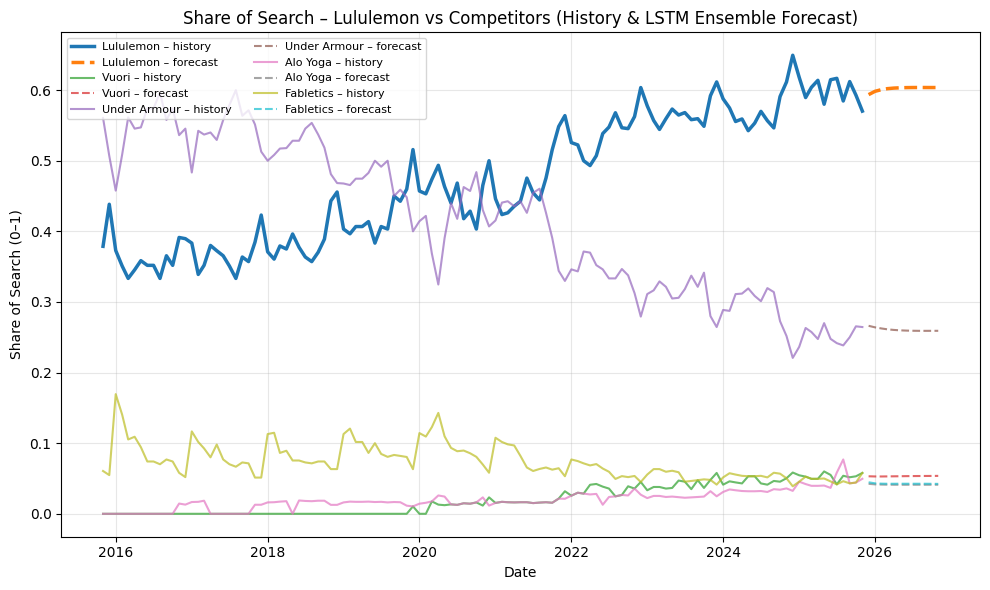

In [ ]:
# ==== LSTM ENSEMBLE FOR SHARE OF SEARCH (ALL IN ONE CELL) ====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 1) Prepare data -------------------------------------------------

sos.index = pd.to_datetime(sos.index)
sos = sos.sort_index()
sos = sos.fillna(method="ffill").fillna(method="bfill")   # just in case

values = sos.values
window = 12          # use last 12 months to predict next month
future_steps = 12    # forecast horizon: 12 months; change to 24 for 2 years

def create_sequences(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :])     # last 12 months
        y.append(data[i+window, :])       # next month
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(values, window=window)
X_train, y_train = X_all, y_all

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# 2) Define a single-run LSTM train + forecast function -----------

def train_and_forecast_once():
    """Train one LSTM on SoS and return its forecast (future_steps x n_features)."""
    model = Sequential([
        LSTM(32, input_shape=(timesteps, n_features)),
        Dense(n_features, activation="linear")
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss="mse")

    model.fit(X_train, y_train, epochs=80, batch_size=8, verbose=0)

    current_window = values[-window:, :]   # last 12 months of SoS
    future_sos_scaled = []

    for _ in range(future_steps):
        X_input = current_window[np.newaxis, :, :]        # (1, 12, n_features)
        y_hat = model.predict(X_input, verbose=0)[0]      # (n_features,)

        # optional renormalization so shares sum to 1
        total = y_hat.sum()
        if total > 0:
            y_hat = y_hat / total

        future_sos_scaled.append(y_hat)
        current_window = np.vstack([current_window[1:], y_hat])

    return np.array(future_sos_scaled)

# 3) Run ensemble and average -------------------------------------

n_runs = 50
all_runs = np.stack([train_and_forecast_once() for _ in range(n_runs)], axis=0)
# shape: (n_runs, future_steps, n_features)

avg_future_sos = all_runs.mean(axis=0)   # (future_steps, n_features)

# 4) Build future DataFrame with dates -----------------------------

freq = pd.infer_freq(sos.index)
if freq is None:
    freq = "MS"

last_date = sos.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.DateOffset(months=1),
    periods=future_steps,
    freq=freq
)

future_sos_df = pd.DataFrame(avg_future_sos, index=future_index, columns=sos.columns)

# 5) Plot: history + ensemble forecast for all brands --------------

plt.figure(figsize=(10, 6))

for col in sos.columns:
    base_name = col.replace("SoS_", "").replace("_", " ").title()
    is_lulu = "lululemon" in col.lower()
    lw = 2.5 if is_lulu else 1.5
    alpha = 1.0 if is_lulu else 0.7

    # history
    plt.plot(sos.index, sos[col],
             label=f"{base_name} – history",
             linewidth=lw, alpha=alpha)

    # forecast
    plt.plot(future_sos_df.index, future_sos_df[col],
             linestyle="--",
             linewidth=lw, alpha=alpha,
             label=f"{base_name} – forecast")

plt.title("Share of Search – Lululemon vs Competitors (History & LSTM Ensemble Forecast)")
plt.xlabel("Date")
plt.ylabel("Share of Search (0–1)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


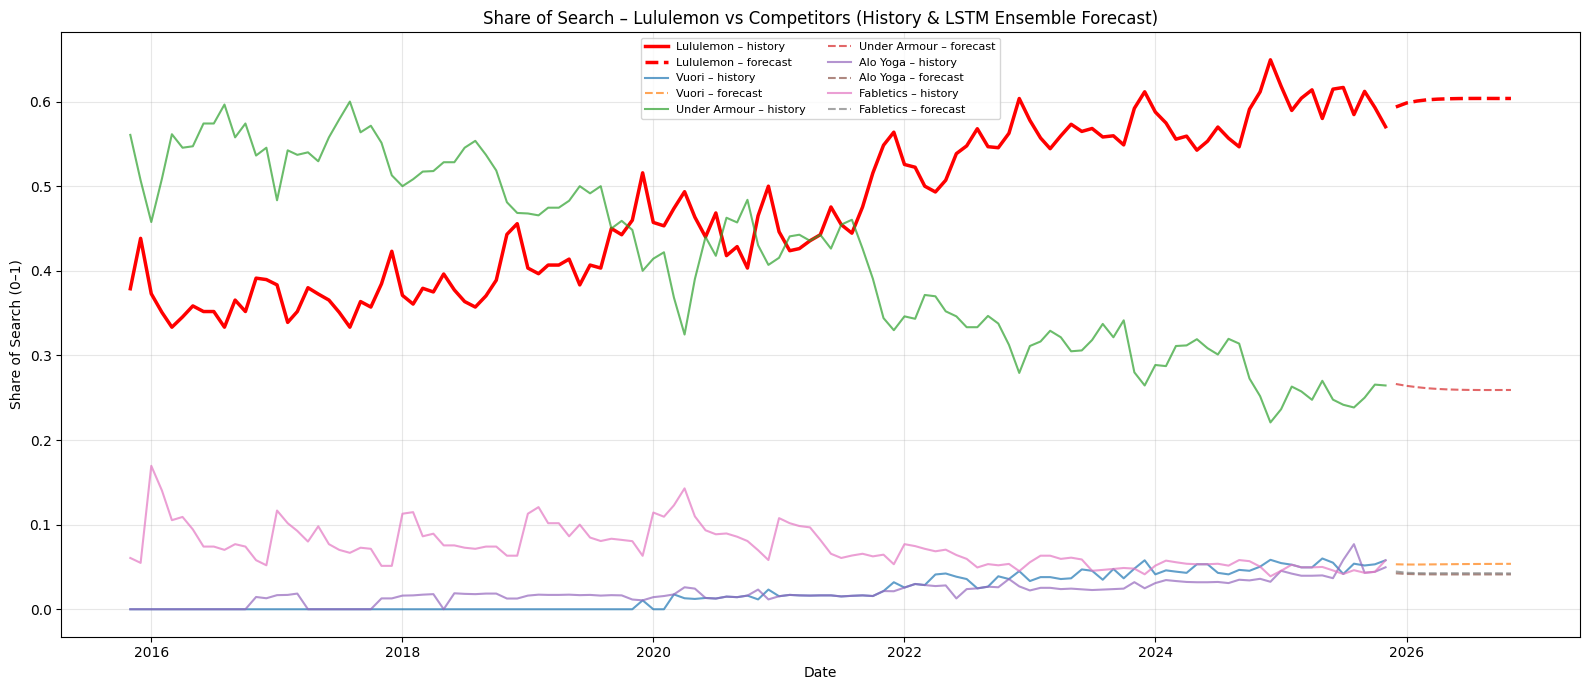

In [ ]:
plt.figure(figsize=(16, 7))
for col in sos.columns:
    base_name = col.replace("SoS_", "").replace("_", " ").title()
    is_lulu = "lululemon" in col.lower()
    lw = 2.5 if is_lulu else 1.5
    alpha = 1.0 if is_lulu else 0.7

    # choose color for lululemon only
    color_kwargs = {"color": "red"} if is_lulu else {}

    # history
    plt.plot(
        sos.index,
        sos[col],
        label=f"{base_name} – history",
        linewidth=lw,
        alpha=alpha,
        **color_kwargs
    )

    # forecast
    plt.plot(
        future_sos_df.index,
        future_sos_df[col],
        linestyle="--",
        linewidth=lw,
        alpha=alpha,
        label=f"{base_name} – forecast",
        **color_kwargs
    )

plt.title("Share of Search – Lululemon vs Competitors (History & LSTM Ensemble Forecast)")
plt.xlabel("Date")
plt.ylabel("Share of Search (0–1)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
